In [1]:
import pandas as pd
import pyproj
from shapely.geometry import Point
from shapely.ops import transform
import numpy as np

In [2]:
df = pd.read_csv('OD_matrix_201803.csv',encoding='unicode_escape')

<AxesSubplot:xlabel='X_start', ylabel='Y_start'>

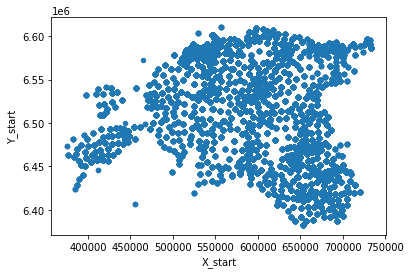

In [3]:
df.plot.scatter('X_start','Y_start')

It is similar to the map of Estonia, but the projection is a bit  weird. At least it is not `4326` nor `3857`. It is in the local projection of `3300`.

In [4]:
df

,KANT_start,KANT_end,start_kant_id,end_kant_id,X_start,Y_start,X_end,Y_end,route_id,Population,RegularMovers
0,Aakre Valga,Aakre Valga,1,1,627213.008799,6.440209e+06,627213.008799,6.440209e+06,1697,470,96
1,Aakre Valga,Annikoru Tartu,1,25,627213.008799,6.440209e+06,634298.193717,6.461856e+06,21178,470,1
2,Aakre Valga,Elva linn,1,49,627213.008799,6.440209e+06,642136.014361,6.456563e+06,41506,470,12
3,Aakre Valga,Elva ümbruse kant Tartu,1,50,627213.008799,6.440209e+06,639265.501560,6.453032e+06,42353,470,1
4,Aakre Valga,Hellenurme Valga,1,81,627213.008799,6.440209e+06,640178.641901,6.447022e+06,68610,470,2
...,...,...,...,...,...,...,...,...,...,...,...
28504,Ülenurme Tartu,Võnnu Tartu,839,810,659202.938891,6.468463e+06,681155.798401,6.464204e+06,686062,4959,6
28505,Ülenurme Tartu,Võru linn,839,812,659202.938891,6.468463e+06,678417.528347,6.414736e+06,687756,4959,6
28506,Ülenurme Tartu,Võõpste Tartu,839,816,659202.938891,6.468463e+06,683260.892473,6.473663e+06,691144,4959,1
28507,Ülenurme Tartu,Välgi Tartu,839,823,659202.938891,6.468463e+06,669844.459691,6.497459e+06,697073,4959,1


In [5]:
len(df.KANT_start.unique())

845

In [6]:
len(df.KANT_end.unique())

844

In [7]:
set(df.KANT_start.unique()) - set(df.KANT_end.unique())

{'Vilsandi Saare'}

In [8]:
set(df.KANT_end.unique()) - set(df.KANT_start.unique())

set()

Then, the `KANT_start.unique()` has all the locaions we need to transform.

In [9]:
start = df.groupby('KANT_start').first()

In [10]:
start

,KANT_end,start_kant_id,end_kant_id,X_start,Y_start,X_end,Y_end,route_id,Population,RegularMovers
KANT_start,,,,,,,,,,
Aakre Valga,Aakre Valga,1,1,627213.008799,6.440209e+06,627213.008799,6.440209e+06,1697,470,96
Aardla Tartu,Aardla Tartu,2,2,664206.080560,6.466176e+06,664206.080560,6.466176e+06,2545,1087,239
Aarna Põlva,Aarna Põlva,3,3,674944.509786,6.441704e+06,674944.509786,6.441704e+06,3393,243,19
Aaspere Lääne-Viru,Aaspere Lääne-Viru,4,4,620838.092143,6.592462e+06,620838.092143,6.592462e+06,4241,441,173
Abja Viljandi,Abja-Paluoja linn,6,5,579178.093070,6.441166e+06,579742.050531,6.444023e+06,5090,564,154
...,...,...,...,...,...,...,...,...,...,...
Ääsmäe Harju,Aruküla Harju,837,34,529187.870955,6.566963e+06,561079.126772,6.580363e+06,29635,1266,2
Õisu Viljandi,Abja-Paluoja linn,832,5,588943.147572,6.452916e+06,579742.050531,6.444023e+06,5914,455,19
Õru Valga,Aakre Valga,833,1,627647.829537,6.423045e+06,627213.008799,6.440209e+06,2527,354,1


In [11]:
def transformer(x,y):
    EPSG_3300 = pyproj.CRS('EPSG:3300')
    EPSG_4326 = pyproj.CRS('EPSG:4326')


    project = pyproj.Transformer.from_crs(EPSG_3300, EPSG_4326, always_xy=True).transform
    EPSG_4326_point = transform(project, Point(x,y))
    return (EPSG_4326_point.x,EPSG_4326_point.y)

In [12]:
start_locations  = list(map(transformer,start.X_start,start.Y_start))

In [13]:
start_points = dict(zip(start.index.values,start_locations))

In [14]:
start_points

{'Aakre Valga': (26.156788237152732, 58.08466134586742),
 'Aardla Tartu': (26.801714698052198, 58.30537662967389),
 'Aarna Põlva': (26.966251310856475, 58.08171064873707),
 'Aaspere Lääne-Viru': (26.130748790252124, 59.45267813133137),
 'Abja Viljandi': (25.3429986163856, 58.10449982522518),
 'Abja-Paluoja linn': (25.353539709866514, 58.130047257391354),
 'Abruka Saare': (22.50792722217055, 58.14918362365007),
 'Adavere Jõgeva': (25.88753349548646, 58.72843957661713),
 'Adila-Pihali Rapla': (24.60671269671119, 59.12111204048698),
 'Aegviidu alev': (25.620198418138187, 59.27945751753878),
 'Ahja Põlva': (27.062040570276512, 58.20543953768209),
 'Ahula Järva': (25.755975681088003, 59.102976779491094),
 'Ahunapalu Tartu': (27.26216564885708, 58.32896242384805),
 'Aidu Ida-Viru': (27.09210811048234, 59.318010778352004),
 'Aidu Jõgeva': (26.192823131444424, 58.74646159688926),
 'Alajõe Ida-Viru': (27.430275918338047, 59.03216854491108),
 'Alatskivi Tartu': (27.125046560010613, 58.5850620135

In [18]:
def substiute(st,nd):
    st_lng = start_points[st][0]
    st_lat = start_points[st][1]
    nd_lng = start_points[nd][0]
    nd_lat = start_points[nd][1]

    return st_lng, nd_lng, st_lat, nd_lat

In [21]:
ndf = pd.DataFrame(list(map(substiute,df.KANT_start,df.KANT_end)),columns=['long1','long2','lat1','lat2'])

In [22]:
ndf

,long1,long2,lat1,lat2
0,26.156788,26.156788,58.084661,58.084661
1,26.156788,26.289343,58.084661,58.276801
2,26.156788,26.419587,58.084661,58.226836
3,26.156788,26.368641,58.084661,58.196071
4,26.156788,26.380533,58.084661,58.141861
...,...,...,...,...
28504,26.718025,27.088977,58.327739,58.281003
28505,26.718025,27.004591,58.327739,57.838429
28506,26.718025,27.132347,58.327739,58.364961
28507,26.718025,26.921028,58.327739,58.583826


In [23]:
ndf.to_csv('od.csv',index=False)